In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

TensorFlow 1.x selected.


--- Create and Train a Simple MNIST CNN Classifier ---

In [0]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [0]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [4]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

sess = tf.Session()
keras.backend.set_session(sess)

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 34s 564us/sample - loss: 1.1130 - categorical_accuracy: 0.6332 - val_loss: 0.3407 - val_categorical_accuracy: 0.9041
Epoch 2/12
60000/60000 [==============================] - 33s 558us/sample - loss: 0.5022 - categorical_accuracy: 0.8438 - val_loss: 0.2368 - val_categorical_accuracy: 0.9336
Epoch 3/12
60000/60000 [==============================] - 34s 561us/sample - loss: 0.3920 - categorical_accuracy: 0.8788 - val_loss: 0.1881 - val_categorical_accuracy: 0.9442
Epoch 4/12
60000/60000 [==============================] - 34s 565us/sample - loss: 0.3288 - categorical_accuracy: 0.8998 - val_loss: 0.1555 - val_categorical_accuracy: 0.9553
Epoch 5/12
60000/60000 [==============================] - 34s 565us/sample - loss: 0.2828 - categorical_accuracy: 0.9158 - val_loss: 0.1349 - val_categorical_accuracy: 0

--- TF Only FGSM Implementation ---

In [0]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [0]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def TF_FastGradientSignMethod(model, images, labels, epsilon):
    adv_loss = keras.losses.categorical_crossentropy(labels, model(images))
    adv_grads = tf.gradients(adv_loss, images)[0]
    adv_out = images + epsilon * tf.math.sign(adv_grads)
    return adv_out

In [0]:
images = tf.Variable(test_images)
attack_labels = tf.Variable(test_labels)
adv_out = TF_FastGradientSignMethod(model, images, attack_labels, epsilon=0.3)

Test loss: 5.51
Successfully moved out of source class: 0.97
Mean perturbation distance: 0.29


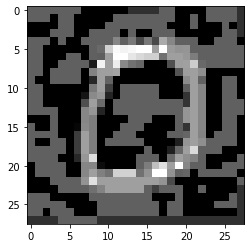

In [10]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:test_labels
                                         })
TestAttack(model, adv_images, test_images, test_labels)

--- TF Only TGSM Implementation ---

In [0]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TF_TargetedGradientSignMethod(model, images, target, epsilon):
    adv_loss = keras.losses.categorical_crossentropy(target, model(images))
    adv_grads = tf.gradients(adv_loss, images)[0]
    adv_out = images - epsilon * tf.math.sign(adv_grads)
    return adv_out

In [0]:
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
images = tf.Variable(test_images)
attack_labels = tf.Variable(target)
adv_out = TF_TargetedGradientSignMethod(model, images, attack_labels, epsilon=0.3)

Test loss: 4.35
Successfully moved out of source class: 0.94
Test loss: 1.20
Successfully perturbed to target class: 0.57
Mean perturbation distance: 0.29


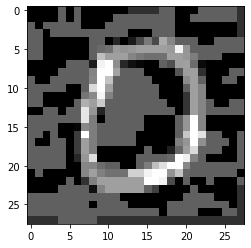

In [13]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:target
                                         })
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

--- TF Only BIM Implementation ---

In [0]:
def TF_BasicIterativeMethod(model, images, labels, epsilon, iter_eps, iterations=10, targeted=False):
    
    adv_out = tf.identity(images)
    targeted_tensor = tf.constant(targeted)
    
    def cond(images, adv_out):
        return True
    
    def perturb(images, adv_out):
        
        # Perturb with FGSM or TGSM
        def tgsm_base():
            return TF_TargetedGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
    
        def fgsm_base():
            return TF_FastGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
        adv_out = tf.cond(targeted_tensor, tgsm_base, fgsm_base)     
        
        # Project the perturbation to the epsilon ball
        perturbation = adv_out - images
        norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = tf.sqrt(tf.maximum(10e-12, norm))
        factor = tf.minimum(1.0, tf.divide(epsilon, norm))
        adv_out = tf.clip_by_value(images + perturbation * factor, 0.0, 1.0)
        
        return images, adv_out
        
    _,adv_out = tf.while_loop(cond, perturb, (images, adv_out), back_prop=True, maximum_iterations=iterations)
    
    return adv_out

In [0]:
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
images = tf.Variable(test_images)
attack_labels = tf.Variable(target)
adv_out = TF_BasicIterativeMethod(model, images, attack_labels, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=True)

Test loss: 3.48
Successfully moved out of source class: 0.82
Test loss: 0.69
Successfully perturbed to target class: 0.79
Mean perturbation distance: 0.14


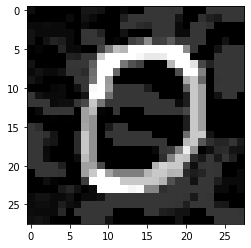

In [16]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:target
                                         })
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)